# BASE 0 - CI

Information:

* Database: base 0
* Predicted variable: Corrupción Intensa
* Type of prediction: Clasification
* Periodo: 2016-2020
* Subset: Casos con gastos corrientes

## 1. Load data and Libraries

In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
import pandas as  pd
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt

In [3]:
path = r'..\..\..\input\preprocessed_data\base0.csv'
data = pd.read_csv( path )

In [4]:
data.shape

(1382, 14510)

In [5]:
data[ 'corrup_intensa' ].value_counts( normalize = True )*100

1.0    71.852388
0.0    28.147612
Name: corrup_intensa, dtype: float64

In [6]:
data[ 'corrup_intensa' ].value_counts()

1.0    993
0.0    389
Name: corrup_intensa, dtype: int64

Quedarse solo con casos de gastos corrientes, y borrar la variable gasto

In [7]:
data = data[ data[ 'variable_gasto' ] == 1 ]
data = data.drop( 'variable_gasto', 
                  axis = 1 )

## 2. Split variables

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
dep_var    = [ 'corrup_intensa' ]
other_vars = [ 'monto_examinado', 'monto_auditado', 'monto_objeto_servicio', 
               'monto_corrup1', 'monto_corrup2', 'tipo_control', 'corrup_amplia',
               'per_corrup1', 'per_corrup2', '_monto', 'monto_', 'year', 'ubigeo' ]

pred_vars  = [ col for col in data.columns if col not in dep_var and col not in other_vars ]

x_train, x_test, y_train, y_test = train_test_split( data[ pred_vars ], 
                                                     data[ 'corrup_intensa' ], 
                                                     test_size    = 0.25,
                                                     random_state = 2023 )

## 3. Resampling

#### 3.1 SMOTE TOMEK

In [10]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter 

os_us = SMOTETomek( random_state         = 2023, 
                    sampling_strategy    = 'all' )

x_train_smote_tomek, y_train_smote_tomek = os_us.fit_resample( x_train, y_train )

#### 3.2 SMOTE

In [11]:
os_us = SMOTE( random_state      = 2023, 
               sampling_strategy = 'all' )

x_train_smote, y_train_smote = os_us.fit_resample( x_train, y_train )

#### 3.3 Naive random sampling

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler( random_state = 2023 )

x_train_ros, y_train_ros = ros.fit_resample( x_train, y_train )

### 3.4. Check data and variables percentage

In [13]:
check_data      = np.zeros( ( 4, 4 ) )

check_data[ 0 ] = [ x_train.shape[ 0 ], x_train.shape[ 1 ], 
                    y_train.value_counts()[ 0 ], y_train.value_counts()[ 1 ] ]

check_data[ 1 ] = [ x_train_smote.shape[ 0 ], x_train_smote.shape[ 1 ], 
                    y_train_smote.value_counts()[ 0 ], y_train_smote.value_counts()[ 1 ] ]

check_data[ 2 ] = [ x_train_smote_tomek.shape[ 0 ], x_train_smote_tomek.shape[ 1 ],
                    y_train_smote_tomek.value_counts()[ 0 ], y_train_smote_tomek.value_counts()[ 1 ] ]

check_data[ 3 ] = [ x_train_ros.shape[ 0 ], x_train_ros.shape[ 1 ],
                    y_train_ros.value_counts()[ 0 ], y_train_ros.value_counts()[ 1 ] ]

colnames        = [ 'observaciones', 'variables', 'Nro. No', 'Nro. Si' ]

rownames        = [ 'Original',
                    'SMOTE',
                    'SOMTE Tomek',
                    'NRS' ]

table_check_data = pd.DataFrame( check_data, columns = colnames )
table_check_data.index = rownames
table_check_data

,observaciones,variables,Nro. No,Nro. Si
Original,411.0,14502.0,123.0,288.0
SMOTE,576.0,14502.0,288.0,288.0
SOMTE Tomek,496.0,14502.0,248.0,248.0
NRS,576.0,14502.0,288.0,288.0


In [14]:
# Calculate the percentage of variables to be included for the original dataset

o_20 = 20*x_train.shape[ 1 ]/100
o_30 = 30*x_train.shape[ 1 ]/100
o_40 = 40*x_train.shape[ 1 ]/100

print( o_20, o_30, o_40, sep = '\n' )

2900.4
4350.6
5800.8


## 4. Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [16]:
%%time

# Implementing the model
lg_model_o          = LogisticRegression( random_state = 2023 ).fit( x_train, y_train )
lg_model_s          = LogisticRegression( random_state = 2023 ).fit( x_train_smote, y_train_smote )
lg_model_st         = LogisticRegression( random_state = 2023 ).fit( x_train_smote_tomek, y_train_smote_tomek )
lg_model_nrs        = LogisticRegression( random_state = 2023 ).fit( x_train_ros, y_train_ros )

# Predict over test set
y_lg_pred_class_o   = lg_model_o.predict( x_test )
y_lg_pred_prob_o    = lg_model_o.predict_proba( x_test )[ :, 1 ]

y_lg_pred_class_s   = lg_model_s.predict( x_test )
y_lg_pred_prob_s    = lg_model_s.predict_proba( x_test )[ :, 1 ]

y_lg_pred_class_st  = lg_model_st.predict( x_test )
y_lg_pred_prob_st   = lg_model_st.predict_proba( x_test )[ :, 1 ]

y_lg_pred_class_nrs = lg_model_nrs.predict( x_test )
y_lg_pred_prob_nrs  = lg_model_nrs.predict_proba( x_test )[ :, 1 ]

Wall time: 4.85 s


In [17]:
# Calculating clasiffication report
columns             = [ 'no', 'si' ]
lg_report_o         = classification_report( y_test, y_lg_pred_class_o, target_names = columns, output_dict = True )
lg_report_s         = classification_report( y_test, y_lg_pred_class_s, target_names = columns, output_dict = True )
lg_report_st        = classification_report( y_test, y_lg_pred_class_st, target_names = columns, output_dict = True )
lg_report_nrs       = classification_report( y_test, y_lg_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
lg_no_precision_o   = lg_report_o[ 'no' ][ 'precision' ]
lg_no_recall_o      = lg_report_o[ 'no' ][ 'recall' ]
lg_no_f1_score_o    = lg_report_o[ 'no' ][ 'f1-score' ]

lg_si_precision_o   = lg_report_o[ 'si' ][ 'precision' ]
lg_si_recall_o      = lg_report_o[ 'si' ][ 'recall' ]
lg_si_f1_score_o    = lg_report_o[ 'si' ][ 'f1-score' ]

accuracy_lg_o       = accuracy_score( y_test, y_lg_pred_class_o )
log_loss_lg_o       = log_loss( y_test, y_lg_pred_class_o )
roc_auc_lg_o        = roc_auc_score( y_test, y_lg_pred_prob_o )
f1_score_lg_o       = f1_score( y_test, y_lg_pred_class_s, average = 'binary' )

# Calculating metrics for the SMOTE model
lg_no_precision_s   = lg_report_s[ 'no' ][ 'precision' ]
lg_no_recall_s      = lg_report_s[ 'no' ][ 'recall' ]
lg_no_f1_score_s    = lg_report_s[ 'no' ][ 'f1-score' ]

lg_si_precision_s   = lg_report_s[ 'si' ][ 'precision' ]
lg_si_recall_s      = lg_report_s[ 'si' ][ 'recall' ]
lg_si_f1_score_s    = lg_report_s[ 'si' ][ 'f1-score' ]

accuracy_lg_s       = accuracy_score( y_test, y_lg_pred_class_s )
log_loss_lg_s       = log_loss( y_test, y_lg_pred_class_s )
roc_auc_lg_s        = roc_auc_score( y_test, y_lg_pred_prob_s )
f1_score_lg_s       = f1_score( y_test, y_lg_pred_class_s, average = 'binary' )

# Calculating metrics for the SMOTE Tomek model
lg_no_precision_st  = lg_report_st[ 'no' ][ 'precision' ]
lg_no_recall_st     = lg_report_st[ 'no' ][ 'recall' ]
lg_no_f1_score_st   = lg_report_st[ 'no' ][ 'f1-score' ]

lg_si_precision_st  = lg_report_st[ 'si' ][ 'precision' ]
lg_si_recall_st     = lg_report_st[ 'si' ][ 'recall' ]
lg_si_f1_score_st   = lg_report_st[ 'si' ][ 'f1-score' ]

accuracy_lg_st      = accuracy_score( y_test, y_lg_pred_class_st )
log_loss_lg_st      = log_loss( y_test, y_lg_pred_class_st )
roc_auc_lg_st       = roc_auc_score( y_test, y_lg_pred_prob_st )
f1_score_lg_st      = f1_score( y_test, y_lg_pred_class_st, average = 'binary' )

# Calculating metrics for the NRS model
lg_no_precision_nrs = lg_report_st[ 'no' ][ 'precision' ]
lg_no_recall_nrs    = lg_report_st[ 'no' ][ 'recall' ]
lg_no_f1_score_nrs  = lg_report_st[ 'no' ][ 'f1-score' ]

lg_si_precision_nrs = lg_report_st[ 'si' ][ 'precision' ]
lg_si_recall_nrs    = lg_report_st[ 'si' ][ 'recall' ]
lg_si_f1_score_nrs  = lg_report_st[ 'si' ][ 'f1-score' ]

accuracy_lg_nrs     = accuracy_score( y_test, y_lg_pred_class_nrs )
log_loss_lg_nrs     = log_loss( y_test, y_lg_pred_class_nrs )
roc_auc_lg_nrs      = roc_auc_score( y_test, y_lg_pred_prob_nrs )
f1_score_lg_nrs     = f1_score( y_test, y_lg_pred_class_nrs, average = 'binary' )

## 5. Regularization Methods (Lasso, Ridge and Elastic Net)

In [18]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

## 5.1. Lasso

In [19]:
%%time

# Implementing the model
lasso_model_o          = LogisticRegressionCV( penalty = 'l1', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train, y_train )

lasso_model_s          = LogisticRegressionCV( penalty = 'l1', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_smote, y_train_smote )

lasso_model_st         = LogisticRegressionCV( penalty = 'l1', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_smote_tomek, y_train_smote_tomek )

lasso_model_nrs        = LogisticRegressionCV( penalty = 'l1', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_ros, y_train_ros )

# Predict over test set
y_lasso_pred_class_o   = lasso_model_o.predict( x_test )
y_lasso_pred_prob_o    = lasso_model_o.predict_proba( x_test )[ :, 1 ]

y_lasso_pred_class_s   = lasso_model_s.predict( x_test )
y_lasso_pred_prob_s    = lasso_model_s.predict_proba( x_test )[ :, 1 ]

y_lasso_pred_class_st  = lasso_model_st.predict( x_test )
y_lasso_pred_prob_st   = lasso_model_st.predict_proba( x_test )[ :, 1 ]

y_lasso_pred_class_nrs = lasso_model_nrs.predict( x_test )
y_lasso_pred_prob_nrs  = lasso_model_nrs.predict_proba( x_test )[ :, 1 ]

Wall time: 20min 7s


In [20]:
# Calculating clasiffication report
columns                = [ 'no', 'si' ]
lasso_report_o         = classification_report( y_test, y_lasso_pred_class_o, target_names = columns, output_dict = True )
lasso_report_s         = classification_report( y_test, y_lasso_pred_class_s, target_names = columns, output_dict = True )
lasso_report_st        = classification_report( y_test, y_lasso_pred_class_st, target_names = columns, output_dict = True )
lasso_report_nrs       = classification_report( y_test, y_lasso_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
lasso_no_precision_o   = lasso_report_o[ 'no' ][ 'precision' ]
lasso_no_recall_o      = lasso_report_o[ 'no' ][ 'recall' ]
lasso_no_f1_score_o    = lasso_report_o[ 'no' ][ 'f1-score' ]

lasso_si_precision_o   = lasso_report_o[ 'si' ][ 'precision' ]
lasso_si_recall_o      = lasso_report_o[ 'si' ][ 'recall' ]
lasso_si_f1_score_o    = lasso_report_o[ 'si' ][ 'f1-score' ]

accuracy_lasso_o       = accuracy_score( y_test, y_lasso_pred_class_o )
log_loss_lasso_o       = log_loss( y_test, y_lasso_pred_class_o )
roc_auc_lasso_o        = roc_auc_score( y_test, y_lasso_pred_prob_o )
f1_score_lasso_o       = f1_score( y_test, y_lasso_pred_class_o, average = 'binary' )

# Calculating metrics for the SMOTE model
lasso_no_precision_s   = lasso_report_s[ 'no' ][ 'precision' ]
lasso_no_recall_s      = lasso_report_s[ 'no' ][ 'recall' ]
lasso_no_f1_score_s    = lasso_report_s[ 'no' ][ 'f1-score' ]

lasso_si_precision_s   = lasso_report_s[ 'si' ][ 'precision' ]
lasso_si_recall_s      = lasso_report_s[ 'si' ][ 'recall' ]
lasso_si_f1_score_s    = lasso_report_s[ 'si' ][ 'f1-score' ]

accuracy_lasso_s       = accuracy_score( y_test, y_lasso_pred_class_s )
log_loss_lasso_s       = log_loss( y_test, y_lasso_pred_class_s )
roc_auc_lasso_s        = roc_auc_score( y_test, y_lasso_pred_prob_s )
f1_score_lasso_s       = f1_score( y_test, y_lasso_pred_class_s, average = 'binary' )

# Calculating metrics for the SMOTE Tomek model
lasso_no_precision_st  = lasso_report_st[ 'no' ][ 'precision' ]
lasso_no_recall_st     = lasso_report_st[ 'no' ][ 'recall' ]
lasso_no_f1_score_st   = lasso_report_st[ 'no' ][ 'f1-score' ]

lasso_si_precision_st  = lasso_report_st[ 'si' ][ 'precision' ]
lasso_si_recall_st     = lasso_report_st[ 'si' ][ 'recall' ]
lasso_si_f1_score_st   = lasso_report_st[ 'si' ][ 'f1-score' ]

accuracy_lasso_st      = accuracy_score( y_test, y_lasso_pred_class_st )
log_loss_lasso_st      = log_loss( y_test, y_lasso_pred_class_st )
roc_auc_lasso_st       = roc_auc_score( y_test, y_lasso_pred_prob_st )
f1_score_lasso_st      = f1_score( y_test, y_lasso_pred_class_st, average = 'binary' )

# Calculating metrics for the NRS model
lasso_no_precision_nrs = lasso_report_nrs[ 'no' ][ 'precision' ]
lasso_no_recall_nrs    = lasso_report_nrs[ 'no' ][ 'recall' ]
lasso_no_f1_score_nrs  = lasso_report_nrs[ 'no' ][ 'f1-score' ]

lasso_si_precision_nrs = lasso_report_nrs[ 'si' ][ 'precision' ]
lasso_si_recall_nrs = lasso_report_nrs[ 'si' ][ 'recall' ]
lasso_si_f1_score_nrs = lasso_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_lasso_nrs = accuracy_score( y_test, y_lasso_pred_class_nrs )
log_loss_lasso_nrs = log_loss( y_test, y_lasso_pred_class_nrs )
roc_auc_lasso_nrs = roc_auc_score( y_test, y_lasso_pred_prob_nrs )
f1_score_lasso_nrs = f1_score( y_test, y_lasso_pred_class_nrs, average = 'binary' )

In [21]:
# coef_series = pd.DataFrame( data = lasso_model_o.coef_.reshape(-1, 1), index = lasso_model_o.feature_names_in_ )
# a = coef_series.sort_values(by=0, ascending = False, key = abs )
# a.to_excel('a.xlsx')

## 5.2. Ridge

In [22]:
%%time

# Implementing the model
ridge_model_o          = LogisticRegressionCV( penalty = 'l2', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train, y_train )

ridge_model_s          = LogisticRegressionCV( penalty = 'l2', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_smote, y_train_smote )

ridge_model_st         = LogisticRegressionCV( penalty = 'l2', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_smote_tomek, y_train_smote_tomek )

ridge_model_nrs        = LogisticRegressionCV( penalty = 'l2', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_ros, y_train_ros )

# Predict over test set
y_ridge_pred_class_o   = ridge_model_o.predict( x_test )
y_ridge_pred_prob_o    = ridge_model_o.predict_proba( x_test )[ :, 1 ]

y_ridge_pred_class_s   = ridge_model_s.predict( x_test )
y_ridge_pred_prob_s    = ridge_model_s.predict_proba( x_test )[ :, 1 ]

y_ridge_pred_class_st  = ridge_model_st.predict( x_test )
y_ridge_pred_prob_st   = ridge_model_st.predict_proba( x_test )[ :, 1 ]

y_ridge_pred_class_nrs = ridge_model_nrs.predict( x_test )
y_ridge_pred_prob_nrs  = ridge_model_nrs.predict_proba( x_test )[ :, 1 ]

Wall time: 11min 54s


In [23]:
# Calculating clasiffication report
columns                = [ 'no', 'si' ]
ridge_report_o         = classification_report( y_test, y_ridge_pred_class_o, target_names = columns, output_dict = True )
ridge_report_s         = classification_report( y_test, y_ridge_pred_class_s, target_names = columns, output_dict = True )
ridge_report_st        = classification_report( y_test, y_ridge_pred_class_st, target_names = columns, output_dict = True )
ridge_report_nrs       = classification_report( y_test, y_ridge_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
ridge_no_precision_o   = ridge_report_o[ 'no' ][ 'precision' ]
ridge_no_recall_o      = ridge_report_o[ 'no' ][ 'recall' ]
ridge_no_f1_score_o    = ridge_report_o[ 'no' ][ 'f1-score' ]

ridge_si_precision_o   = ridge_report_o[ 'si' ][ 'precision' ]
ridge_si_recall_o      = ridge_report_o[ 'si' ][ 'recall' ]
ridge_si_f1_score_o    = ridge_report_o[ 'si' ][ 'f1-score' ]

accuracy_ridge_o       = accuracy_score( y_test, y_ridge_pred_class_o )
log_loss_ridge_o       = log_loss( y_test, y_ridge_pred_class_o )
roc_auc_ridge_o        = roc_auc_score( y_test, y_ridge_pred_prob_o )
f1_score_ridge_o       = f1_score( y_test, y_ridge_pred_class_o, average = 'binary' )

# Calculating metrics for the SMOTE model
ridge_no_precision_s   = ridge_report_s[ 'no' ][ 'precision' ]
ridge_no_recall_s      = ridge_report_s[ 'no' ][ 'recall' ]
ridge_no_f1_score_s    = ridge_report_s[ 'no' ][ 'f1-score' ]

ridge_si_precision_s   = ridge_report_s[ 'si' ][ 'precision' ]
ridge_si_recall_s      = ridge_report_s[ 'si' ][ 'recall' ]
ridge_si_f1_score_s    = ridge_report_s[ 'si' ][ 'f1-score' ]

accuracy_ridge_s       = accuracy_score( y_test, y_ridge_pred_class_s )
log_loss_ridge_s       = log_loss( y_test, y_ridge_pred_class_s )
roc_auc_ridge_s        = roc_auc_score( y_test, y_ridge_pred_prob_s )
f1_score_ridge_s       = f1_score( y_test, y_ridge_pred_class_s, average = 'binary' )

# Calculating metrics for the SMOTE Tomek model
ridge_no_precision_st  = ridge_report_st[ 'no' ][ 'precision' ]
ridge_no_recall_st     = ridge_report_st[ 'no' ][ 'recall' ]
ridge_no_f1_score_st   = ridge_report_st[ 'no' ][ 'f1-score' ]

ridge_si_precision_st  = ridge_report_st[ 'si' ][ 'precision' ]
ridge_si_recall_st     = ridge_report_st[ 'si' ][ 'recall' ]
ridge_si_f1_score_st   = ridge_report_st[ 'si' ][ 'f1-score' ]

accuracy_ridge_st      = accuracy_score( y_test, y_ridge_pred_class_st )
log_loss_ridge_st      = log_loss( y_test, y_ridge_pred_class_st )
roc_auc_ridge_st       = roc_auc_score( y_test, y_ridge_pred_prob_st )
f1_score_ridge_st      = f1_score( y_test, y_ridge_pred_class_st, average = 'binary' )

# Calculating metrics for the NRS model
ridge_no_precision_nrs = ridge_report_nrs[ 'no' ][ 'precision' ]
ridge_no_recall_nrs    = ridge_report_nrs[ 'no' ][ 'recall' ]
ridge_no_f1_score_nrs  = ridge_report_nrs[ 'no' ][ 'f1-score' ]

ridge_si_precision_nrs = ridge_report_nrs[ 'si' ][ 'precision' ]
ridge_si_recall_nrs    = ridge_report_nrs[ 'si' ][ 'recall' ]
ridge_si_f1_score_nrs  = ridge_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_ridge_nrs     = accuracy_score( y_test, y_ridge_pred_class_nrs )
log_loss_ridge_nrs     = log_loss( y_test, y_ridge_pred_class_nrs )
roc_auc_ridge_nrs      = roc_auc_score( y_test, y_ridge_pred_prob_nrs )
f1_score_ridge_nrs     = f1_score( y_test, y_ridge_pred_class_nrs, average = 'binary' )

### 5.3. Elastic Net

In [24]:
%%time

# Implementing the model
elasticnet_model_o          = LogisticRegressionCV( penalty = 'elasticnet', solver = 'saga', cv = 10, random_state = 2023, l1_ratios = [ 0.5 ], n_jobs = -1 ).\
                                               fit( x_train, y_train )

elasticnet_model_s          = LogisticRegressionCV( penalty = 'elasticnet', solver = 'saga', cv = 10, random_state = 2023, l1_ratios = [ 0.5 ], n_jobs = -1 ).\
                                               fit( x_train_smote, y_train_smote )

elasticnet_model_st         = LogisticRegressionCV( penalty = 'elasticnet', solver = 'saga', cv = 10, random_state = 2023, l1_ratios = [ 0.5 ], n_jobs = -1 ).\
                                               fit( x_train_smote_tomek, y_train_smote_tomek )

elasticnet_model_nrs        = LogisticRegressionCV( penalty = 'elasticnet', solver = 'saga', cv = 10, random_state = 2023, l1_ratios = [ 0.5 ], n_jobs = -1 ).\
                                               fit( x_train_ros, y_train_ros )


# Predict over test set
y_elasticnet_pred_class_o   = elasticnet_model_o.predict( x_test )
y_elasticnet_pred_prob_o    = elasticnet_model_o.predict_proba( x_test )[ :, 1 ]

y_elasticnet_pred_class_s   = elasticnet_model_s.predict( x_test )
y_elasticnet_pred_prob_s    = elasticnet_model_s.predict_proba( x_test )[ :, 1 ]

y_elasticnet_pred_class_st  = elasticnet_model_st.predict( x_test )
y_elasticnet_pred_prob_st   = elasticnet_model_st.predict_proba( x_test )[ :, 1 ]

y_elasticnet_pred_class_nrs = elasticnet_model_nrs.predict( x_test )
y_elasticnet_pred_prob_nrs  = elasticnet_model_nrs.predict_proba( x_test )[ :, 1 ]

Wall time: 19min 38s


In [25]:
# Calculating clasiffication report
columns                     = [ 'no', 'si' ]
elasticnet_report_o         = classification_report( y_test, y_elasticnet_pred_class_o, target_names = columns, output_dict = True )
elasticnet_report_s         = classification_report( y_test, y_elasticnet_pred_class_s, target_names = columns, output_dict = True )
elasticnet_report_st        = classification_report( y_test, y_elasticnet_pred_class_st, target_names = columns, output_dict = True )
elasticnet_report_nrs       = classification_report( y_test, y_elasticnet_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
elasticnet_no_precision_o   = elasticnet_report_o[ 'no' ][ 'precision' ]
elasticnet_no_recall_o      = elasticnet_report_o[ 'no' ][ 'recall' ]
elasticnet_no_f1_score_o    = elasticnet_report_o[ 'no' ][ 'f1-score' ]

elasticnet_si_precision_o   = elasticnet_report_o[ 'si' ][ 'precision' ]
elasticnet_si_recall_o      = elasticnet_report_o[ 'si' ][ 'recall' ]
elasticnet_si_f1_score_o    = elasticnet_report_o[ 'si' ][ 'f1-score' ]

accuracy_elasticnet_o       = accuracy_score( y_test, y_elasticnet_pred_class_o )
log_loss_elasticnet_o       = log_loss( y_test, y_elasticnet_pred_class_o )
roc_auc_elasticnet_o        = roc_auc_score( y_test, y_elasticnet_pred_prob_o )
f1_score_elasticnet_o       = f1_score( y_test, y_elasticnet_pred_class_o, average = 'binary' )

# Calculating metrics for the SMOTE model
elasticnet_no_precision_s   = elasticnet_report_s[ 'no' ][ 'precision' ]
elasticnet_no_recall_s      = elasticnet_report_s[ 'no' ][ 'recall' ]
elasticnet_no_f1_score_s    = elasticnet_report_s[ 'no' ][ 'f1-score' ]

elasticnet_si_precision_s   = elasticnet_report_s[ 'si' ][ 'precision' ]
elasticnet_si_recall_s      = elasticnet_report_s[ 'si' ][ 'recall' ]
elasticnet_si_f1_score_s    = elasticnet_report_s[ 'si' ][ 'f1-score' ]

accuracy_elasticnet_s       = accuracy_score( y_test, y_elasticnet_pred_class_s )
log_loss_elasticnet_s       = log_loss( y_test, y_elasticnet_pred_class_s )
roc_auc_elasticnet_s        = roc_auc_score( y_test, y_elasticnet_pred_prob_s )
f1_score_elasticnet_s       = f1_score( y_test, y_elasticnet_pred_class_s, average = 'binary' )

# Calculating metrics for the SMOTE Tomek model
elasticnet_no_precision_st  = elasticnet_report_st[ 'no' ][ 'precision' ]
elasticnet_no_recall_st     = elasticnet_report_st[ 'no' ][ 'recall' ]
elasticnet_no_f1_score_st   = elasticnet_report_st[ 'no' ][ 'f1-score' ]

elasticnet_si_precision_st  = elasticnet_report_st[ 'si' ][ 'precision' ]
elasticnet_si_recall_st     = elasticnet_report_st[ 'si' ][ 'recall' ]
elasticnet_si_f1_score_st   = elasticnet_report_st[ 'si' ][ 'f1-score' ]

accuracy_elasticnet_st      = accuracy_score( y_test, y_elasticnet_pred_class_st )
log_loss_elasticnet_st      = log_loss( y_test, y_elasticnet_pred_class_st )
roc_auc_elasticnet_st       = roc_auc_score( y_test, y_elasticnet_pred_prob_st )
f1_score_elasticnet_st      = f1_score( y_test, y_elasticnet_pred_class_st, average = 'binary' )

# Calculating metrics for the NRS model
elasticnet_no_precision_nrs = elasticnet_report_nrs[ 'no' ][ 'precision' ]
elasticnet_no_recall_nrs    = elasticnet_report_nrs[ 'no' ][ 'recall' ]
elasticnet_no_f1_score_nrs  = elasticnet_report_nrs[ 'no' ][ 'f1-score' ]

elasticnet_si_precision_nrs = elasticnet_report_nrs[ 'si' ][ 'precision' ]
elasticnet_si_recall_nrs    = elasticnet_report_nrs[ 'si' ][ 'recall' ]
elasticnet_si_f1_score_nrs  = elasticnet_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_elasticnet_nrs     = accuracy_score( y_test, y_elasticnet_pred_class_nrs )
log_loss_elasticnet_nrs     = log_loss( y_test, y_elasticnet_pred_class_nrs )
roc_auc_elasticnet_nrs      = roc_auc_score( y_test, y_elasticnet_pred_prob_nrs )
f1_score_elasticnet_nrs     = f1_score( y_test, y_elasticnet_pred_class_nrs, average = 'binary' )

## 6. Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [27]:
%%time

# Set the model (Comentado)
rf_model = RandomForestClassifier( random_state = 2023,
                                   n_jobs = -1 )

# Define param grid (Comentado)
rf_param_grid = {
    'n_estimators': [ 250, 500, 1000 ],
    'max_features': [ 2900, 4351, 5801 ],
    'max_depth': [ 10, 20, 30 ]
}

# Set up cross-validation strategy
cv = KFold( n_splits = 5, shuffle = True, random_state = 2023 )

# Grid search (Comentado)
rf_search_o = GridSearchCV( estimator = rf_model,
                            param_grid = rf_param_grid,
                            cv = cv,
                            n_jobs = -1 )

rf_search_s = GridSearchCV( estimator = rf_model,
                            param_grid = rf_param_grid,
                            cv = cv,
                            n_jobs = -1 )

rf_search_st = GridSearchCV( estimator = rf_model,
                             param_grid = rf_param_grid,
                             cv = cv,
                             n_jobs = -1 )

rf_search_nrs = GridSearchCV( estimator = rf_model,
                              param_grid = rf_param_grid,
                              cv = cv,
                              n_jobs = -1 )

# Fit different models (Comentado)
rf_search_o.fit( x_train, y_train )
rf_search_s.fit( x_train_smote, y_train_smote )
rf_search_st.fit( x_train_smote_tomek, y_train_smote_tomek )
rf_search_nrs.fit( x_train_ros, y_train_ros )

# Print best params and best score (Comentado)
print( f'Original dataset: { rf_search_o.best_params_ }' )
print( f'SMOTE dataset: { rf_search_s.best_params_ }' )
print( f'SMOTE Tomek dataset: { rf_search_st.best_params_ }' )
print( f'NRS dataset: { rf_search_nrs.best_params_ }' )

# Select best params (Comentado)
rf_max_features_o   = rf_search_o.best_params_[ 'max_features' ] 
rf_n_estimators_o   = rf_search_o.best_params_[ 'n_estimators' ] 

rf_max_features_s   = rf_search_s.best_params_[ 'max_features' ] 
rf_n_estimators_s   = rf_search_s.best_params_[ 'n_estimators' ] 

rf_max_features_st  = rf_search_st.best_params_[ 'max_features' ] 
rf_n_estimators_st  = rf_search_st.best_params_[ 'n_estimators' ] 

rf_max_features_nrs = rf_search_nrs.best_params_[ 'max_features' ] 
rf_n_estimators_nrs = rf_search_nrs.best_params_[ 'n_estimators' ]

Original dataset: {'max_depth': 10, 'max_features': 2900, 'n_estimators': 1000}
SMOTE dataset: {'max_depth': 20, 'max_features': 5801, 'n_estimators': 1000}
SMOTE Tomek dataset: {'max_depth': 10, 'max_features': 4351, 'n_estimators': 500}
NRS dataset: {'max_depth': 10, 'max_features': 2900, 'n_estimators': 500}
Wall time: 3h 26min 13s


In [28]:
# Train the optimal models
rf_optimal_model_o = RandomForestClassifier( max_features = rf_max_features_o, 
                                             n_estimators = rf_n_estimators_o,
                                             random_state = 2023,
                                             n_jobs = -1 )

rf_optimal_model_s = RandomForestClassifier( max_features = rf_max_features_s, 
                                             n_estimators = rf_n_estimators_s,
                                             random_state = 2023,
                                             n_jobs = -1 )

rf_optimal_model_st = RandomForestClassifier( max_features = rf_max_features_st, 
                                              n_estimators = rf_n_estimators_st,
                                              random_state = 2023,
                                              n_jobs = -1 )

rf_optimal_model_nrs = RandomForestClassifier( max_features = rf_max_features_nrs, 
                                               n_estimators = rf_n_estimators_nrs,
                                               random_state = 2023,
                                               n_jobs = -1 )

rf_optimal_model_o.fit( x_train, y_train )
rf_optimal_model_s.fit( x_train_smote, y_train_smote )
rf_optimal_model_st.fit( x_train_smote_tomek, y_train_smote_tomek )
rf_optimal_model_nrs.fit( x_train_ros, y_train_ros )

# Apply over test set
y_rf_pred_class_o   = rf_optimal_model_o.predict( x_test )
y_rf_pred_prob_o    = rf_optimal_model_o.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_s   = rf_optimal_model_s.predict( x_test )
y_rf_pred_prob_s    = rf_optimal_model_s.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_st  = rf_optimal_model_st.predict( x_test )
y_rf_pred_prob_st   = rf_optimal_model_st.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_nrs = rf_optimal_model_nrs.predict( x_test )
y_rf_pred_prob_nrs  = rf_optimal_model_nrs.predict_proba( x_test )[ :, 1 ]

In [29]:
# Calculating clasiffication report
columns             = [ 'no', 'si' ]
rf_report_o         = classification_report( y_test, y_rf_pred_class_o, target_names = columns, output_dict = True )
rf_report_s         = classification_report( y_test, y_rf_pred_class_s, target_names = columns, output_dict = True )
rf_report_st        = classification_report( y_test, y_rf_pred_class_st, target_names = columns, output_dict = True )
rf_report_nrs       = classification_report( y_test, y_rf_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
rf_no_precision_o   = rf_report_o[ 'no' ][ 'precision' ]
rf_no_recall_o      = rf_report_o[ 'no' ][ 'recall' ]
rf_no_f1_score_o    = rf_report_o[ 'no' ][ 'f1-score' ]

rf_si_precision_o   = rf_report_o[ 'si' ][ 'precision' ]
rf_si_recall_o      = rf_report_o[ 'si' ][ 'recall' ]
rf_si_f1_score_o    = rf_report_o[ 'si' ][ 'f1-score' ]

accuracy_rf_o       = accuracy_score( y_test, y_rf_pred_class_o )
log_loss_rf_o       = log_loss( y_test, y_rf_pred_class_o )
roc_auc_rf_o        = roc_auc_score( y_test, y_rf_pred_prob_o )
f1_score_rf_o       = f1_score( y_test, y_rf_pred_class_o, average = 'binary' )

# Calculating metrics for the SMOTE model
rf_no_precision_s   = rf_report_s[ 'no' ][ 'precision' ]
rf_no_recall_s      = rf_report_s[ 'no' ][ 'recall' ]
rf_no_f1_score_s    = rf_report_s[ 'no' ][ 'f1-score' ]

rf_si_precision_s   = rf_report_s[ 'si' ][ 'precision' ]
rf_si_recall_s      = rf_report_s[ 'si' ][ 'recall' ]
rf_si_f1_score_s    = rf_report_s[ 'si' ][ 'f1-score' ]

accuracy_rf_s       = accuracy_score( y_test, y_rf_pred_class_s )
log_loss_rf_s       = log_loss( y_test, y_rf_pred_class_s )
roc_auc_rf_s        = roc_auc_score( y_test, y_rf_pred_prob_s )
f1_score_rf_s       = f1_score( y_test, y_rf_pred_class_s, average = 'binary' )

# Calculating metrics for the SMOTE Tomek model
rf_no_precision_st  = rf_report_st[ 'no' ][ 'precision' ]
rf_no_recall_st     = rf_report_st[ 'no' ][ 'recall' ]
rf_no_f1_score_st   = rf_report_st[ 'no' ][ 'f1-score' ]

rf_si_precision_st  = rf_report_st[ 'si' ][ 'precision' ]
rf_si_recall_st     = rf_report_st[ 'si' ][ 'recall' ]
rf_si_f1_score_st   = rf_report_st[ 'si' ][ 'f1-score' ]

accuracy_rf_st      = accuracy_score( y_test, y_rf_pred_class_st )
log_loss_rf_st      = log_loss( y_test, y_rf_pred_class_st )
roc_auc_rf_st       = roc_auc_score( y_test, y_rf_pred_prob_st )
f1_score_rf_st      = f1_score( y_test, y_rf_pred_class_st, average = 'binary' )

# Calculating metrics for the NRS model
rf_no_precision_nrs = rf_report_nrs[ 'no' ][ 'precision' ]
rf_no_recall_nrs    = rf_report_nrs[ 'no' ][ 'recall' ]
rf_no_f1_score_nrs  = rf_report_nrs[ 'no' ][ 'f1-score' ]

rf_si_precision_nrs = rf_report_nrs[ 'si' ][ 'precision' ]
rf_si_recall_nrs    = rf_report_nrs[ 'si' ][ 'recall' ]
rf_si_f1_score_nrs  = rf_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_rf_nrs     = accuracy_score( y_test, y_rf_pred_class_nrs )
log_loss_rf_nrs     = log_loss( y_test, y_rf_pred_class_nrs )
roc_auc_rf_nrs      = roc_auc_score( y_test, y_rf_pred_prob_nrs )
f1_score_rf_nrs     = f1_score( y_test, y_rf_pred_class_nrs, average = 'binary' )

## 7. Boosted Trees

In [30]:
from xgboost import XGBClassifier

In [31]:
%%time

# Set the model (Comentrario) 
xgb_model = XGBClassifier( use_label_encoder = False, 
                           objective = 'binary:logistic', 
                           verbosity = 0,
                           learning_rate = 0.1,
                           random_state = 2023,
                           n_jobs = -1 )

# Define param grid (Comentrario)
xgb_param_grid = {
    'n_estimators': [ 250, 500, 1000 ],
    'max_features': [ 2900, 4351, 5801 ],
    'max_depth': [ 1, 2 ]
}

# Set up cross-validation strategy
cv = KFold( n_splits = 5, shuffle = True, random_state = 2023 )

# Grid search (Comentrario)
xgb_search_o = GridSearchCV( estimator = xgb_model,
                             param_grid = xgb_param_grid,
                             cv = cv,
                             n_jobs = -1 )

xgb_search_s = GridSearchCV( estimator = xgb_model,
                             param_grid = xgb_param_grid,
                             cv = cv,
                             n_jobs = -1 )

xgb_search_st = GridSearchCV( estimator = xgb_model,
                              param_grid = xgb_param_grid,
                              cv = cv,
                              n_jobs = -1 )

xgb_search_nrs = GridSearchCV( estimator = xgb_model,
                               param_grid = xgb_param_grid,
                               cv = cv,
                               n_jobs = -1 )

# Fit different models (Comentrario)
xgb_search_o.fit( x_train, y_train )
xgb_search_s.fit( x_train_smote, y_train_smote )
xgb_search_st.fit( x_train_smote_tomek, y_train_smote_tomek )
xgb_search_nrs.fit( x_train_ros, y_train_ros )

# Print best params and best scores (Comentrario)
print( xgb_search_o.best_params_ )
print( xgb_search_s.best_params_ )
print( xgb_search_st.best_params_ )
print( xgb_search_nrs.best_params_ )

# Select best params (Comentrario)
xgb_max_features_o   = xgb_search_o.best_params_[ 'max_features' ] 
xgb_max_depth_o      = xgb_search_o.best_params_[ 'max_depth' ] 
xgb_n_estimators_o   = xgb_search_o.best_params_[ 'n_estimators' ] 

xgb_max_features_s   = xgb_search_s.best_params_[ 'max_features' ] 
xgb_max_depth_s      = xgb_search_s.best_params_[ 'max_depth' ] 
xgb_n_estimators_s   = xgb_search_s.best_params_[ 'n_estimators' ] 

xgb_max_features_st  = xgb_search_st.best_params_[ 'max_features' ] 
xgb_max_depth_st     = xgb_search_st.best_params_[ 'max_depth' ] 
xgb_n_estimators_st  = xgb_search_st.best_params_[ 'n_estimators' ] 

xgb_max_features_nrs = xgb_search_nrs.best_params_[ 'max_features' ] 
xgb_max_depth_nrs    = xgb_search_nrs.best_params_[ 'max_depth' ] 
xgb_n_estimators_nrs = xgb_search_nrs.best_params_[ 'n_estimators' ]

{'max_depth': 1, 'max_features': 2900, 'n_estimators': 250}
{'max_depth': 1, 'max_features': 2900, 'n_estimators': 250}
{'max_depth': 2, 'max_features': 2900, 'n_estimators': 250}
{'max_depth': 2, 'max_features': 2900, 'n_estimators': 500}
Wall time: 2h 12min 37s


In [32]:
# Train the optimal model
xgb_optimal_model_o = XGBClassifier( objective = 'binary:logistic', 
                                     verbosity = 0,
                                     learning_rate = 0.1,
                                     max_features = xgb_max_features_o,
                                     max_depth = xgb_max_depth_o,
                                     n_estimators = xgb_n_estimators_o,
                                     random_state = 2023,
                                     n_jobs = -1 )

xgb_optimal_model_s = XGBClassifier( objective = 'binary:logistic', 
                                     verbosity = 0,
                                     learning_rate = 0.1,
                                     max_features = xgb_max_features_s,
                                     max_depth = xgb_max_depth_s,
                                     n_estimators = xgb_n_estimators_s,
                                     random_state = 2023,
                                     n_jobs = -1 )

xgb_optimal_model_st = XGBClassifier( objective = 'binary:logistic', 
                                      verbosity = 0,
                                      learning_rate = 0.1,
                                      max_features = xgb_max_features_st, 
                                      max_depth = xgb_max_depth_st,
                                      n_estimators = xgb_n_estimators_st,
                                      random_state = 2023,
                                      n_jobs = -1 )

xgb_optimal_model_nrs = XGBClassifier( objective = 'binary:logistic', 
                                       verbosity = 0,
                                       learning_rate = 0.1,
                                       max_features = xgb_max_features_nrs, 
                                       max_depth = xgb_max_depth_nrs,
                                       n_estimators = xgb_n_estimators_nrs,
                                       random_state = 2023,
                                       n_jobs = -1 )

xgb_optimal_model_o.fit( x_train, y_train )
xgb_optimal_model_s.fit( x_train_smote, y_train_smote )
xgb_optimal_model_st.fit( x_train_smote_tomek, y_train_smote_tomek )
xgb_optimal_model_nrs.fit( x_train_ros, y_train_ros )

# Apply over test set
y_xgb_pred_class_o   = xgb_optimal_model_o.predict( x_test )
y_xgb_pred_prob_o    = xgb_optimal_model_o.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_s   = xgb_optimal_model_s.predict( x_test )
y_xgb_pred_prob_s    = xgb_optimal_model_s.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_st  = xgb_optimal_model_st.predict( x_test )
y_xgb_pred_prob_st   = xgb_optimal_model_st.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_nrs = xgb_optimal_model_nrs.predict( x_test )
y_xgb_pred_prob_nrs  = xgb_optimal_model_nrs.predict_proba( x_test )[ :, 1 ]

In [33]:
# Calculating clasiffication report
columns              = [ 'no', 'si' ]
xgb_report_o         = classification_report( y_test, y_xgb_pred_class_o, target_names = columns, output_dict = True )
xgb_report_s         = classification_report( y_test, y_xgb_pred_class_s, target_names = columns, output_dict = True )
xgb_report_st        = classification_report( y_test, y_xgb_pred_class_st, target_names = columns, output_dict = True )
xgb_report_nrs       = classification_report( y_test, y_xgb_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
xgb_no_precision_o   = xgb_report_o[ 'no' ][ 'precision' ]
xgb_no_recall_o      = xgb_report_o[ 'no' ][ 'recall' ]
xgb_no_f1_score_o    = xgb_report_o[ 'no' ][ 'f1-score' ]

xgb_si_precision_o   = xgb_report_o[ 'si' ][ 'precision' ]
xgb_si_recall_o      = xgb_report_o[ 'si' ][ 'recall' ]
xgb_si_f1_score_o    = xgb_report_o[ 'si' ][ 'f1-score' ]

accuracy_xgb_o       = accuracy_score( y_test, y_xgb_pred_class_o )
log_loss_xgb_o       = log_loss( y_test, y_xgb_pred_class_o )
roc_auc_xgb_o        = roc_auc_score( y_test, y_xgb_pred_prob_o )
f1_score_xgb_o       = f1_score( y_test, y_xgb_pred_class_o, average = 'binary' )

# Calculating metrics for the SMOTE model
xgb_no_precision_s   = xgb_report_s[ 'no' ][ 'precision' ]
xgb_no_recall_s      = xgb_report_s[ 'no' ][ 'recall' ]
xgb_no_f1_score_s    = xgb_report_s[ 'no' ][ 'f1-score' ]

xgb_si_precision_s   = xgb_report_s[ 'si' ][ 'precision' ]
xgb_si_recall_s      = xgb_report_s[ 'si' ][ 'recall' ]
xgb_si_f1_score_s    = xgb_report_s[ 'si' ][ 'f1-score' ]

accuracy_xgb_s       = accuracy_score( y_test, y_xgb_pred_class_s )
log_loss_xgb_s       = log_loss( y_test, y_xgb_pred_class_s )
roc_auc_xgb_s        = roc_auc_score( y_test, y_xgb_pred_prob_s )
f1_score_xgb_s       = f1_score( y_test, y_xgb_pred_class_s, average = 'binary' )

# Calculating metrics for the SMOTE Tomek model
xgb_no_precision_st  = xgb_report_st[ 'no' ][ 'precision' ]
xgb_no_recall_st     = xgb_report_st[ 'no' ][ 'recall' ]
xgb_no_f1_score_st   = xgb_report_st[ 'no' ][ 'f1-score' ]

xgb_si_precision_st  = xgb_report_st[ 'si' ][ 'precision' ]
xgb_si_recall_st     = xgb_report_st[ 'si' ][ 'recall' ]
xgb_si_f1_score_st   = xgb_report_st[ 'si' ][ 'f1-score' ]

accuracy_xgb_st      = accuracy_score( y_test, y_xgb_pred_class_st )
log_loss_xgb_st      = log_loss( y_test, y_xgb_pred_class_st )
roc_auc_xgb_st       = roc_auc_score( y_test, y_xgb_pred_prob_st )
f1_score_xgb_st      = f1_score( y_test, y_xgb_pred_class_st, average = 'binary' )

# Calculating metrics for the NRS model
xgb_no_precision_nrs = xgb_report_nrs[ 'no' ][ 'precision' ]
xgb_no_recall_nrs    = xgb_report_nrs[ 'no' ][ 'recall' ]
xgb_no_f1_score_nrs  = xgb_report_nrs[ 'no' ][ 'f1-score' ]

xgb_si_precision_nrs = xgb_report_nrs[ 'si' ][ 'precision' ]
xgb_si_recall_nrs    = xgb_report_nrs[ 'si' ][ 'recall' ]
xgb_si_f1_score_nrs  = xgb_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_xgb_nrs     = accuracy_score( y_test, y_xgb_pred_class_nrs )
log_loss_xgb_nrs     = log_loss( y_test, y_xgb_pred_class_nrs )
roc_auc_xgb_nrs      = roc_auc_score( y_test, y_xgb_pred_prob_nrs )
f1_score_xgb_nrs     = f1_score( y_test, y_xgb_pred_class_nrs, average = 'binary' )

## 8. Resultados Test

In [34]:
# Calculate Matthews Correlation Coefficient
from sklearn.metrics import matthews_corrcoef

mcc_lg_o           = matthews_corrcoef( y_test, y_lg_pred_class_o )
mcc_lg_s           = matthews_corrcoef( y_test, y_lg_pred_class_s )
mcc_lg_st          = matthews_corrcoef( y_test, y_lg_pred_class_st )
mcc_lg_nrs         = matthews_corrcoef( y_test, y_lg_pred_class_nrs )

mcc_lasso_o        = matthews_corrcoef( y_test, y_lasso_pred_class_o )
mcc_lasso_s        = matthews_corrcoef( y_test, y_lasso_pred_class_s )
mcc_lasso_st       = matthews_corrcoef( y_test, y_lasso_pred_class_st )
mcc_lasso_nrs      = matthews_corrcoef( y_test, y_lasso_pred_class_nrs )

mcc_ridge_o        = matthews_corrcoef( y_test, y_ridge_pred_class_o )
mcc_ridge_s        = matthews_corrcoef( y_test, y_ridge_pred_class_s )
mcc_ridge_st       = matthews_corrcoef( y_test, y_ridge_pred_class_st )
mcc_ridge_nrs      = matthews_corrcoef( y_test, y_ridge_pred_class_nrs )

mcc_elasticnet_o   = matthews_corrcoef( y_test, y_elasticnet_pred_class_o )
mcc_elasticnet_s   = matthews_corrcoef( y_test, y_elasticnet_pred_class_s )
mcc_elasticnet_st  = matthews_corrcoef( y_test, y_elasticnet_pred_class_st )
mcc_elasticnet_nrs = matthews_corrcoef( y_test, y_elasticnet_pred_class_nrs )

mcc_rf_o           = matthews_corrcoef( y_test, y_rf_pred_class_o )
mcc_rf_s           = matthews_corrcoef( y_test, y_rf_pred_class_s )
mcc_rf_st          = matthews_corrcoef( y_test, y_rf_pred_class_st )
mcc_rf_nrs         = matthews_corrcoef( y_test, y_rf_pred_class_nrs )

mcc_xgb_o          = matthews_corrcoef( y_test, y_xgb_pred_class_o )
mcc_xgb_s          = matthews_corrcoef( y_test, y_xgb_pred_class_s )
mcc_xgb_st         = matthews_corrcoef( y_test, y_xgb_pred_class_st )
mcc_xgb_nrs        = matthews_corrcoef( y_test, y_xgb_pred_class_nrs )

In [35]:
table = np.zeros( ( 24, 10 ) )

table[ 0 ] = [ accuracy_lg_o, roc_auc_lg_o, f1_score_lg_o, mcc_lg_o, lg_no_precision_o, lg_no_recall_o, 
               lg_no_f1_score_o, lg_si_precision_o, lg_si_recall_o, lg_si_f1_score_o ]

table[ 1 ] = [ accuracy_lg_s, roc_auc_lg_s, f1_score_lg_s, mcc_lg_s, lg_no_precision_s, lg_no_recall_s, 
               lg_no_f1_score_s, lg_si_precision_s, lg_si_recall_s, lg_si_f1_score_s ]

table[ 2 ] = [ accuracy_lg_st, roc_auc_lg_st, f1_score_lg_st, mcc_lg_st, lg_no_precision_st, lg_no_recall_st, 
               lg_no_f1_score_st, lg_si_precision_st, lg_si_recall_st, lg_si_f1_score_st ]

table[ 3 ] = [ accuracy_lg_nrs, roc_auc_lg_nrs, f1_score_lg_nrs, mcc_lg_nrs, lg_no_precision_nrs, lg_no_recall_nrs, 
               lg_no_f1_score_nrs, lg_si_precision_nrs, lg_si_recall_nrs, lg_si_f1_score_nrs ]

table[ 4 ] = [ accuracy_lasso_o, roc_auc_lasso_o, f1_score_lasso_o, mcc_lasso_o, lasso_no_precision_o, lasso_no_recall_o, 
               lasso_no_f1_score_o, lasso_si_precision_o, lasso_si_recall_o, lasso_si_f1_score_o ]

table[ 5 ] = [ accuracy_lasso_s, roc_auc_lasso_s, f1_score_lasso_s, mcc_lasso_s, lasso_no_precision_s, lasso_no_recall_s, 
               lasso_no_f1_score_s, lasso_si_precision_s, lasso_si_recall_s, lasso_si_f1_score_s ]

table[ 6 ] = [ accuracy_lasso_st, roc_auc_lasso_st, f1_score_lasso_st, mcc_lasso_st, lasso_no_precision_st, lasso_no_recall_st, 
               lasso_no_f1_score_st, lasso_si_precision_st, lasso_si_recall_st, lasso_si_f1_score_st ]

table[ 7 ] = [ accuracy_lasso_nrs, roc_auc_lasso_nrs, f1_score_lasso_nrs, mcc_lasso_nrs, lasso_no_precision_nrs, lasso_no_recall_nrs, 
               lasso_no_f1_score_nrs, lasso_si_precision_nrs, lasso_si_recall_nrs, lasso_si_f1_score_nrs ]

table[ 8 ] = [ accuracy_ridge_o, roc_auc_ridge_o, f1_score_ridge_o, mcc_ridge_o, ridge_no_precision_o, ridge_no_recall_o, 
               ridge_no_f1_score_o, ridge_si_precision_o, ridge_si_recall_o, ridge_si_f1_score_o ]

table[ 9 ] = [ accuracy_ridge_s, roc_auc_ridge_s, f1_score_ridge_s, mcc_ridge_s, ridge_no_precision_s, ridge_no_recall_s, 
               ridge_no_f1_score_s, ridge_si_precision_s, ridge_si_recall_s, ridge_si_f1_score_s ]

table[ 10 ] = [ accuracy_ridge_st, roc_auc_ridge_st, f1_score_ridge_st, mcc_ridge_st, ridge_no_precision_st, ridge_no_recall_st, 
               ridge_no_f1_score_st, ridge_si_precision_st, ridge_si_recall_st, ridge_si_f1_score_st ]

table[ 11 ] = [ accuracy_ridge_nrs, roc_auc_ridge_nrs, f1_score_ridge_nrs, mcc_ridge_nrs, ridge_no_precision_nrs, ridge_no_recall_nrs, 
               ridge_no_f1_score_nrs, ridge_si_precision_nrs, ridge_si_recall_nrs, ridge_si_f1_score_nrs ]

table[ 12 ] = [ accuracy_elasticnet_o, roc_auc_elasticnet_o, f1_score_elasticnet_o, mcc_elasticnet_o, elasticnet_no_precision_o, elasticnet_no_recall_o, 
               elasticnet_no_f1_score_o, elasticnet_si_precision_o, elasticnet_si_recall_o, elasticnet_si_f1_score_o ]

table[ 13 ] = [ accuracy_elasticnet_s, roc_auc_elasticnet_s, f1_score_elasticnet_s, mcc_elasticnet_s, elasticnet_no_precision_s, elasticnet_no_recall_s, 
               elasticnet_no_f1_score_s, elasticnet_si_precision_s, elasticnet_si_recall_s, elasticnet_si_f1_score_s ]

table[ 14 ] = [ accuracy_elasticnet_st, roc_auc_elasticnet_st, f1_score_elasticnet_st, mcc_elasticnet_st, elasticnet_no_precision_st, elasticnet_no_recall_st, 
               elasticnet_no_f1_score_st, elasticnet_si_precision_st, elasticnet_si_recall_st, elasticnet_si_f1_score_st ]

table[ 15 ] = [ accuracy_elasticnet_nrs, roc_auc_elasticnet_nrs, f1_score_elasticnet_nrs, mcc_elasticnet_nrs, elasticnet_no_precision_nrs, elasticnet_no_recall_nrs, 
               elasticnet_no_f1_score_nrs, elasticnet_si_precision_nrs, elasticnet_si_recall_nrs, elasticnet_si_f1_score_nrs ]

table[ 16 ] = [ accuracy_rf_o, roc_auc_rf_o, f1_score_rf_o, mcc_rf_o, rf_no_precision_o, rf_no_recall_o, 
               rf_no_f1_score_o, rf_si_precision_o, rf_si_recall_o, rf_si_f1_score_o ]

table[ 17 ] = [ accuracy_rf_s, roc_auc_rf_s, f1_score_rf_s, mcc_rf_s, rf_no_precision_s, rf_no_recall_s, 
               rf_no_f1_score_s, rf_si_precision_s, rf_si_recall_s, rf_si_f1_score_s ]

table[ 18 ] = [ accuracy_rf_st, roc_auc_rf_st, f1_score_rf_st, mcc_rf_st, rf_no_precision_st, rf_no_recall_st, 
               rf_no_f1_score_st, rf_si_precision_st, rf_si_recall_st, rf_si_f1_score_st ]

table[ 19 ] = [ accuracy_rf_nrs, roc_auc_rf_nrs, f1_score_rf_nrs, mcc_rf_nrs, rf_no_precision_nrs, rf_no_recall_nrs, 
               rf_no_f1_score_nrs, rf_si_precision_nrs, rf_si_recall_nrs, rf_si_f1_score_nrs ]

table[ 20 ] = [ accuracy_xgb_o, roc_auc_xgb_o, f1_score_xgb_o, mcc_xgb_o, xgb_no_precision_o, xgb_no_recall_o, 
               xgb_no_f1_score_o, xgb_si_precision_o, xgb_si_recall_o, xgb_si_f1_score_o ]

table[ 21 ] = [ accuracy_xgb_s, roc_auc_xgb_s, f1_score_xgb_s, mcc_xgb_s, xgb_no_precision_s, xgb_no_recall_s, 
               xgb_no_f1_score_s, xgb_si_precision_s, xgb_si_recall_s, xgb_si_f1_score_s ]

table[ 22 ] = [ accuracy_xgb_st, roc_auc_xgb_st, f1_score_xgb_st, mcc_xgb_st, xgb_no_precision_st, xgb_no_recall_st, 
               xgb_no_f1_score_st, xgb_si_precision_st, xgb_si_recall_st, xgb_si_f1_score_st ]

table[ 23 ] = [ accuracy_xgb_nrs, roc_auc_xgb_nrs, f1_score_xgb_nrs, mcc_xgb_nrs, xgb_no_precision_nrs, xgb_no_recall_nrs, 
               xgb_no_f1_score_nrs, xgb_si_precision_nrs, xgb_si_recall_nrs, xgb_si_f1_score_nrs ]

colnames_table = [ "Overall_Accuracy", "Roc_Auc", "Global_F1_Score", "Matthews_Corr_Coef", "No_Precision", 
                   "No_Recall", "No_F1_Score", "Si_Precision", "Si_Recall", "Si_F1_Score" ]
                  
rownames_table = [ "O. Logistic Regression", 
                   "S. Logistic Regression", 
                   "ST. Logistic Regression",                   
                   "NRS. Logistic Regression", 
                   "O. Logistc Lasso",                  
                   "S. Logistc Lasso",
                   "ST. Logistc Lasso",                  
                   "NRS. Logistc Lasso",
                   "O. Logistc Ridge",                   
                   "S. Logistc Ridge", 
                   "ST. Logistc Ridge",                   
                   "NRS. Logistc Ridge", 
                   "O. Logistic Elastic Net",
                   "S. Logistic Elastic Net",                  
                   "ST. Logistic Elastic Net",                  
                   "NRS. Logistic Elastic Net",                  
                   "O. Random Forest",                   
                   "S. Random Forest", 
                   "ST. Random Forest",                   
                   "NRS. Random Forest", 
                   "O. Boosted Trees",                  
                   "S. Boosted Trees",                  
                   "ST. Boosted Trees",
                   "NRS. Boosted Trees" ]                  


table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round( 3 )
table_pandas

,Overall_Accuracy,Roc_Auc,Global_F1_Score,Matthews_Corr_Coef,No_Precision,No_Recall,No_F1_Score,Si_Precision,Si_Recall,Si_F1_Score
O. Logistic Regression,0.679,0.473,0.382,0.115,0.467,0.163,0.241,0.705,0.915,0.796
S. Logistic Regression,0.409,0.565,0.382,-0.014,0.310,0.721,0.434,0.676,0.266,0.382
ST. Logistic Regression,0.336,0.549,0.195,-0.093,0.297,0.814,0.435,0.579,0.117,0.195
NRS. Logistic Regression,0.416,0.559,0.403,-0.015,0.297,0.814,0.435,0.579,0.117,0.195
O. Logistc Lasso,0.672,0.368,0.798,0.033,0.375,0.070,0.118,0.690,0.947,0.798
S. Logistc Lasso,0.453,0.523,0.497,-0.024,0.305,0.581,0.400,0.673,0.394,0.497
ST. Logistc Lasso,0.474,0.502,0.532,-0.005,0.312,0.558,0.400,0.683,0.436,0.532
NRS. Logistc Lasso,0.533,0.478,0.628,0.015,0.322,0.442,0.373,0.692,0.574,0.628
O. Logistc Ridge,0.672,0.368,0.798,0.033,0.375,0.070,0.118,0.690,0.947,0.798
S. Logistc Ridge,0.453,0.523,0.497,-0.024,0.305,0.581,0.400,0.673,0.394,0.497


In [36]:
# Tabla general para Test
table_pandas.to_excel( r'..\..\..\output\ejecucion_3\results\base0_ci_results_test.xlsx' )

## 9. Resultados Train

### 9.1. Random Forest

In [37]:
# Apply over training set
y_rf_pred_class_o_train   = rf_optimal_model_o.predict( x_train )
y_rf_pred_prob_o_train    = rf_optimal_model_o.predict_proba( x_train )[ :, 1 ]

y_rf_pred_class_s_train   = rf_optimal_model_s.predict( x_train )
y_rf_pred_prob_s_train    = rf_optimal_model_s.predict_proba( x_train )[ :, 1 ]

y_rf_pred_class_st_train  = rf_optimal_model_st.predict( x_train )
y_rf_pred_prob_st_train   = rf_optimal_model_st.predict_proba( x_train )[ :, 1 ]

y_rf_pred_class_nrs_train = rf_optimal_model_nrs.predict( x_train )
y_rf_pred_prob_nrs_train  = rf_optimal_model_nrs.predict_proba( x_train )[ :, 1 ]

# Calculating clasiffication report
columns                   = [ 'no', 'si' ]
rf_report_o_train         = classification_report( y_train, y_rf_pred_class_o_train, target_names = columns, output_dict = True )
rf_report_s_train         = classification_report( y_train, y_rf_pred_class_s_train, target_names = columns, output_dict = True )
rf_report_st_train        = classification_report( y_train, y_rf_pred_class_st_train, target_names = columns, output_dict = True )
rf_report_nrs_train       = classification_report( y_train, y_rf_pred_class_nrs_train, target_names = columns, output_dict = True )

# Calculating metrics for the original model
rf_no_precision_o_train   = rf_report_o[ 'no' ][ 'precision' ]
rf_no_recall_o_train      = rf_report_o[ 'no' ][ 'recall' ]
rf_no_f1_score_o_train    = rf_report_o[ 'no' ][ 'f1-score' ]

rf_si_precision_o_train   = rf_report_o[ 'si' ][ 'precision' ]
rf_si_recall_o_train      = rf_report_o[ 'si' ][ 'recall' ]
rf_si_f1_score_o_train    = rf_report_o[ 'si' ][ 'f1-score' ]

accuracy_rf_o_train       = accuracy_score( y_train, y_rf_pred_class_o_train )
log_loss_rf_o_train       = log_loss( y_train, y_rf_pred_class_o_train )
roc_auc_rf_o_train        = roc_auc_score( y_train, y_rf_pred_prob_o_train )
f1_score_rf_o_train       = f1_score( y_train, y_rf_pred_class_o_train, average = 'binary' )

# Calculating metrics for the SMOTE model
rf_no_precision_s_train   = rf_report_s[ 'no' ][ 'precision' ]
rf_no_recall_s_train      = rf_report_s[ 'no' ][ 'recall' ]
rf_no_f1_score_s_train    = rf_report_s[ 'no' ][ 'f1-score' ]

rf_si_precision_s_train   = rf_report_s[ 'si' ][ 'precision' ]
rf_si_recall_s_train      = rf_report_s[ 'si' ][ 'recall' ]
rf_si_f1_score_s_train    = rf_report_s[ 'si' ][ 'f1-score' ]

accuracy_rf_s_train       = accuracy_score( y_train, y_rf_pred_class_s_train )
log_loss_rf_s_train       = log_loss( y_train, y_rf_pred_class_s_train )
roc_auc_rf_s_train        = roc_auc_score( y_train, y_rf_pred_prob_s_train )
f1_score_rf_s_train       = f1_score( y_train, y_rf_pred_class_s_train, average = 'binary' )

# Calculating metrics for the SMOTE Tomek model
rf_no_precision_st_train  = rf_report_st[ 'no' ][ 'precision' ]
rf_no_recall_st_train     = rf_report_st[ 'no' ][ 'recall' ]
rf_no_f1_score_st_train   = rf_report_st[ 'no' ][ 'f1-score' ]

rf_si_precision_st_train  = rf_report_st[ 'si' ][ 'precision' ]
rf_si_recall_st_train     = rf_report_st[ 'si' ][ 'recall' ]
rf_si_f1_score_st_train   = rf_report_st[ 'si' ][ 'f1-score' ]

accuracy_rf_st_train      = accuracy_score( y_train, y_rf_pred_class_st_train )
log_loss_rf_st_train      = log_loss( y_train, y_rf_pred_class_st_train )
roc_auc_rf_st_train       = roc_auc_score( y_train, y_rf_pred_prob_st_train )
f1_score_rf_st_train      = f1_score( y_train, y_rf_pred_class_st_train, average = 'binary' )

# Calculating metrics for the NRS model
rf_no_precision_nrs_train = rf_report_nrs[ 'no' ][ 'precision' ]
rf_no_recall_nrs_train    = rf_report_nrs[ 'no' ][ 'recall' ]
rf_no_f1_score_nrs_train  = rf_report_nrs[ 'no' ][ 'f1-score' ]

rf_si_precision_nrs_train = rf_report_nrs[ 'si' ][ 'precision' ]
rf_si_recall_nrs_train    = rf_report_nrs[ 'si' ][ 'recall' ]
rf_si_f1_score_nrs_train  = rf_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_rf_nrs_train     = accuracy_score( y_train, y_rf_pred_class_nrs_train )
log_loss_rf_nrs_train     = log_loss( y_train, y_rf_pred_class_nrs_train )
roc_auc_rf_nrs_train      = roc_auc_score( y_train, y_rf_pred_prob_nrs_train )
f1_score_rf_nrs_train     = f1_score( y_train, y_rf_pred_class_nrs_train, average = 'binary' )

### 9.2. Boosted Trees

In [38]:
# Apply over test set
y_xgb_pred_class_o_train   = xgb_optimal_model_o.predict( x_train )
y_xgb_pred_prob_o_train    = xgb_optimal_model_o.predict_proba( x_train )[ :, 1 ]

y_xgb_pred_class_s_train   = xgb_optimal_model_s.predict( x_train )
y_xgb_pred_prob_s_train    = xgb_optimal_model_s.predict_proba( x_train )[ :, 1 ]

y_xgb_pred_class_st_train  = xgb_optimal_model_st.predict( x_train )
y_xgb_pred_prob_st_train   = xgb_optimal_model_st.predict_proba( x_train )[ :, 1 ]

y_xgb_pred_class_nrs_train = xgb_optimal_model_nrs.predict( x_train )
y_xgb_pred_prob_nrs_train  = xgb_optimal_model_nrs.predict_proba( x_train )[ :, 1 ]

# Calculating clasiffication report
columns                    = [ 'no', 'si' ]
xgb_report_o_train         = classification_report( y_train, y_xgb_pred_class_o_train, target_names = columns, output_dict = True )
xgb_report_s_train         = classification_report( y_train, y_xgb_pred_class_s_train, target_names = columns, output_dict = True )
xgb_report_st_train        = classification_report( y_train, y_xgb_pred_class_st_train, target_names = columns, output_dict = True )
xgb_report_nrs_train       = classification_report( y_train, y_xgb_pred_class_nrs_train, target_names = columns, output_dict = True )

# Calculating metrics for the original model
xgb_no_precision_o_train   = xgb_report_o[ 'no' ][ 'precision' ]
xgb_no_recall_o_train      = xgb_report_o[ 'no' ][ 'recall' ]
xgb_no_f1_score_o_train    = xgb_report_o[ 'no' ][ 'f1-score' ]

xgb_si_precision_o_train   = xgb_report_o[ 'si' ][ 'precision' ]
xgb_si_recall_o_train      = xgb_report_o[ 'si' ][ 'recall' ]
xgb_si_f1_score_o_train    = xgb_report_o[ 'si' ][ 'f1-score' ]

accuracy_xgb_o_train       = accuracy_score( y_train, y_xgb_pred_class_o_train )
log_loss_xgb_o_train       = log_loss( y_train, y_xgb_pred_class_o_train )
roc_auc_xgb_o_train        = roc_auc_score( y_train, y_xgb_pred_prob_o_train )
f1_score_xgb_o_train       = f1_score( y_train, y_xgb_pred_class_o_train, average = 'binary' )

# Calculating metrics for the SMOTE model
xgb_no_precision_s_train   = xgb_report_s[ 'no' ][ 'precision' ]
xgb_no_recall_s_train      = xgb_report_s[ 'no' ][ 'recall' ]
xgb_no_f1_score_s_train    = xgb_report_s[ 'no' ][ 'f1-score' ]

xgb_si_precision_s_train   = xgb_report_s[ 'si' ][ 'precision' ]
xgb_si_recall_s_train      = xgb_report_s[ 'si' ][ 'recall' ]
xgb_si_f1_score_s_train    = xgb_report_s[ 'si' ][ 'f1-score' ]

accuracy_xgb_s_train       = accuracy_score( y_train, y_xgb_pred_class_s_train )
log_loss_xgb_s_train       = log_loss( y_train, y_xgb_pred_class_s_train )
roc_auc_xgb_s_train        = roc_auc_score( y_train, y_xgb_pred_prob_s_train )
f1_score_xgb_s_train       = f1_score( y_train, y_xgb_pred_class_s_train, average = 'binary' )

# Calculating metrics for the SMOTE Tomek model
xgb_no_precision_st_train  = xgb_report_st[ 'no' ][ 'precision' ]
xgb_no_recall_st_train     = xgb_report_st[ 'no' ][ 'recall' ]
xgb_no_f1_score_st_train   = xgb_report_st[ 'no' ][ 'f1-score' ]

xgb_si_precision_st_train  = xgb_report_st[ 'si' ][ 'precision' ]
xgb_si_recall_st_train     = xgb_report_st[ 'si' ][ 'recall' ]
xgb_si_f1_score_st_train   = xgb_report_st[ 'si' ][ 'f1-score' ]

accuracy_xgb_st_train      = accuracy_score( y_train, y_xgb_pred_class_st_train )
log_loss_xgb_st_train      = log_loss( y_train, y_xgb_pred_class_st_train )
roc_auc_xgb_st_train       = roc_auc_score( y_train, y_xgb_pred_prob_st_train )
f1_score_xgb_st_train      = f1_score( y_train, y_xgb_pred_class_st_train, average = 'binary' )

# Calculating metrics for the NRS model
xgb_no_precision_nrs_train = xgb_report_nrs[ 'no' ][ 'precision' ]
xgb_no_recall_nrs_train    = xgb_report_nrs[ 'no' ][ 'recall' ]
xgb_no_f1_score_nrs_train  = xgb_report_nrs[ 'no' ][ 'f1-score' ]

xgb_si_precision_nrs_train = xgb_report_nrs[ 'si' ][ 'precision' ]
xgb_si_recall_nrs_train    = xgb_report_nrs[ 'si' ][ 'recall' ]
xgb_si_f1_score_nrs_train  = xgb_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_xgb_nrs_train     = accuracy_score( y_train, y_xgb_pred_class_nrs_train )
log_loss_xgb_nrs_train     = log_loss( y_train, y_xgb_pred_class_nrs_train )
roc_auc_xgb_nrs_train      = roc_auc_score( y_train, y_xgb_pred_prob_nrs_train )
f1_score_xgb_nrs_train     = f1_score( y_train, y_xgb_pred_class_nrs_train, average = 'binary' )

### 9.3. Training results summary

In [39]:
mcc_rf_o_train           = matthews_corrcoef( y_train, y_rf_pred_class_o_train )
mcc_rf_s_train           = matthews_corrcoef( y_train, y_rf_pred_class_s_train )
mcc_rf_st_train          = matthews_corrcoef( y_train, y_rf_pred_class_st_train )
mcc_rf_nrs_train         = matthews_corrcoef( y_train, y_rf_pred_class_nrs_train )

mcc_xgb_o_train          = matthews_corrcoef( y_train, y_xgb_pred_class_o_train )
mcc_xgb_s_train          = matthews_corrcoef( y_train, y_xgb_pred_class_s_train )
mcc_xgb_st_train         = matthews_corrcoef( y_train, y_xgb_pred_class_st_train )
mcc_xgb_nrs_train        = matthews_corrcoef( y_train, y_xgb_pred_class_nrs_train )

In [40]:
table = np.zeros( ( 8, 10 ) )

table[ 0 ] = [ accuracy_rf_o_train, roc_auc_rf_o_train, f1_score_rf_o_train, mcc_rf_o_train, rf_no_precision_o_train, rf_no_recall_o_train, 
               rf_no_f1_score_o_train, rf_si_precision_o_train, rf_si_recall_o_train, rf_si_f1_score_o_train ]

table[ 1 ] = [ accuracy_rf_s, roc_auc_rf_s, f1_score_rf_s, mcc_rf_s, rf_no_precision_s, rf_no_recall_s, 
               rf_no_f1_score_s_train, rf_si_precision_s_train, rf_si_recall_s_train, rf_si_f1_score_s_train ]

table[ 2 ] = [ accuracy_rf_st_train, roc_auc_rf_st_train, f1_score_rf_st_train, mcc_rf_st_train, rf_no_precision_st_train, rf_no_recall_st_train, 
               rf_no_f1_score_st_train, rf_si_precision_st_train, rf_si_recall_st_train, rf_si_f1_score_st_train ]

table[ 3 ] = [ accuracy_rf_nrs_train, roc_auc_rf_nrs_train, f1_score_rf_nrs_train, mcc_rf_nrs_train, rf_no_precision_nrs_train, rf_no_recall_nrs_train, 
               rf_no_f1_score_nrs_train, rf_si_precision_nrs_train, rf_si_recall_nrs_train, rf_si_f1_score_nrs_train ]

table[ 4 ] = [ accuracy_xgb_o_train, roc_auc_xgb_o_train, f1_score_xgb_o_train, mcc_xgb_o_train, xgb_no_precision_o_train, xgb_no_recall_o_train, 
               xgb_no_f1_score_o_train, xgb_si_precision_o_train, xgb_si_recall_o_train, xgb_si_f1_score_o_train ]

table[ 5 ] = [ accuracy_xgb_s_train, roc_auc_xgb_s_train, f1_score_xgb_s_train, mcc_xgb_s_train, xgb_no_precision_s_train, xgb_no_recall_s_train, 
               xgb_no_f1_score_s_train, xgb_si_precision_s_train, xgb_si_recall_s_train, xgb_si_f1_score_s_train ]

table[ 6 ] = [ accuracy_xgb_st_train, roc_auc_xgb_st_train, f1_score_xgb_st_train, mcc_xgb_st_train, xgb_no_precision_st_train, xgb_no_recall_st_train, 
               xgb_no_f1_score_st_train, xgb_si_precision_st_train, xgb_si_recall_st_train, xgb_si_f1_score_st_train ]

table[ 7 ] = [ accuracy_xgb_nrs_train, roc_auc_xgb_nrs_train, f1_score_xgb_nrs_train, mcc_xgb_nrs_train, xgb_no_precision_nrs_train, xgb_no_recall_nrs_train, 
               xgb_no_f1_score_nrs_train, xgb_si_precision_nrs_train, xgb_si_recall_nrs_train, xgb_si_f1_score_nrs_train ]

colnames_table = [ "Overall_Accuracy", "Roc_Auc", "Global_F1_Score", "Matthews_Corr_Coef", "No_Precision", 
                   "No_Recall", "No_F1_Score", "Si_Precision", "Si_Recall", "Si_F1_Score" ]
                  
rownames_table = [ "O. Random Forest",                   
                   "S. Random Forest", 
                   "ST. Random Forest",                   
                   "NRS. Random Forest", 
                   "O. Boosted Trees",                  
                   "S. Boosted Trees",                  
                   "ST. Boosted Trees",
                   "NRS. Boosted Trees" ]                  


table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round( 3 )
table_pandas

,Overall_Accuracy,Roc_Auc,Global_F1_Score,Matthews_Corr_Coef,No_Precision,No_Recall,No_F1_Score,Si_Precision,Si_Recall,Si_F1_Score
O. Random Forest,0.985,0.999,0.990,0.965,0.667,0.465,0.548,0.785,0.894,0.836
S. Random Forest,0.759,0.771,0.822,0.452,0.609,0.651,0.629,0.835,0.809,0.822
ST. Random Forest,0.951,0.984,0.965,0.887,0.560,0.651,0.602,0.828,0.766,0.796
NRS. Random Forest,0.985,0.998,0.989,0.966,0.667,0.605,0.634,0.827,0.862,0.844
O. Boosted Trees,0.951,0.994,0.966,0.883,0.656,0.488,0.560,0.790,0.883,0.834
S. Boosted Trees,0.966,0.993,0.976,0.918,0.600,0.628,0.614,0.826,0.809,0.817
ST. Boosted Trees,0.951,0.985,0.965,0.884,0.533,0.558,0.545,0.793,0.777,0.785
NRS. Boosted Trees,0.985,0.999,0.989,0.966,0.625,0.581,0.602,0.814,0.840,0.827


In [41]:
# Tabla general para Test
table_pandas.to_excel( r'..\..\..\output\ejecucion_3\results\base0_ci_results_training.xlsx' )

## 10. ROC Curves

In [42]:
from sklearn import metrics

### 10.1. Test set

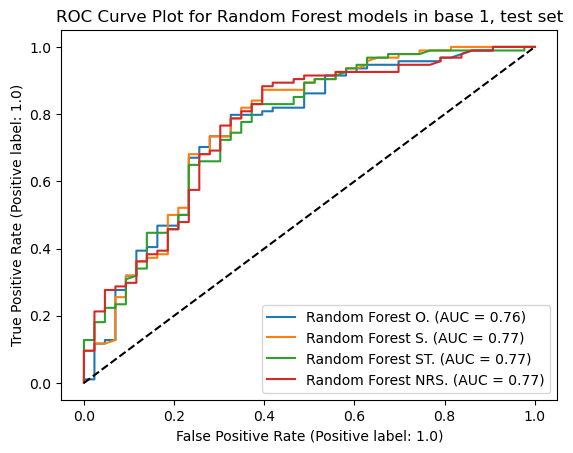

In [43]:
# Random Forest

fig, ax = plt.subplots()

metrics.plot_roc_curve( rf_optimal_model_o, x_test, y_test, ax = ax, name = 'Random Forest O.' )
metrics.plot_roc_curve( rf_optimal_model_s, x_test, y_test, ax = ax, name = 'Random Forest S.' )
metrics.plot_roc_curve( rf_optimal_model_st, x_test, y_test, ax = ax, name = 'Random Forest ST.' )
metrics.plot_roc_curve( rf_optimal_model_nrs, x_test, y_test, ax = ax, name = 'Random Forest NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Random Forest models in base 1, test set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_3\plots\base1\b0_ci_roc_curve_rf_test.jpg', dpi = 300, bbox_inches = 'tight' )

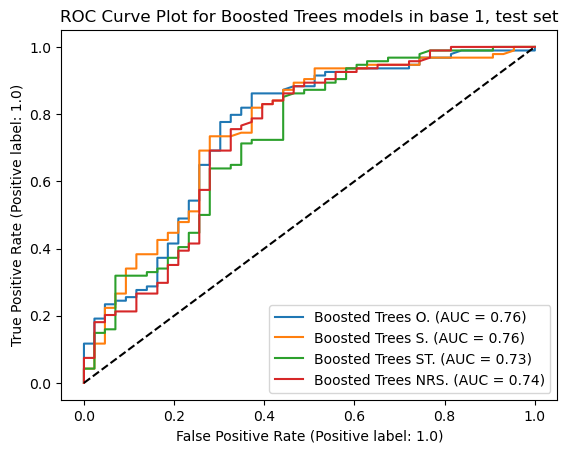

In [44]:
# Boosted Trees

fig, ax = plt.subplots()

metrics.plot_roc_curve( xgb_optimal_model_o, x_test, y_test, ax = ax, name = 'Boosted Trees O.' )
metrics.plot_roc_curve( xgb_optimal_model_s, x_test, y_test, ax = ax, name = 'Boosted Trees S.' )
metrics.plot_roc_curve( xgb_optimal_model_st, x_test, y_test, ax = ax, name = 'Boosted Trees ST.' )
metrics.plot_roc_curve( xgb_optimal_model_nrs, x_test, y_test, ax = ax, name = 'Boosted Trees NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Boosted Trees models in base 1, test set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_3\plots\base1\b0_ci_roc_curve_xgb_test.jpg', dpi = 300, bbox_inches = 'tight' )

### 10.2. Training set

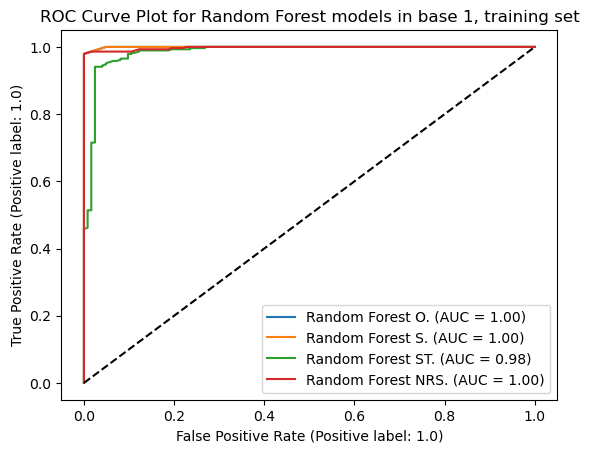

In [45]:
# Random Forest

fig, ax = plt.subplots()

metrics.plot_roc_curve( rf_optimal_model_o, x_train, y_train, ax = ax, name = 'Random Forest O.' )
metrics.plot_roc_curve( rf_optimal_model_s, x_train, y_train, ax = ax, name = 'Random Forest S.' )
metrics.plot_roc_curve( rf_optimal_model_st, x_train, y_train, ax = ax, name = 'Random Forest ST.' )
metrics.plot_roc_curve( rf_optimal_model_nrs, x_train, y_train, ax = ax, name = 'Random Forest NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Random Forest models in base 1, training set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_3\plots\base1\b0_ci_roc_curve_rf_training.jpg', dpi = 300, bbox_inches = 'tight' )

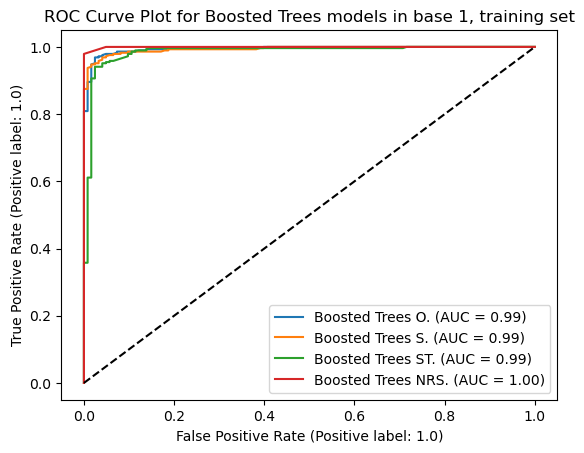

In [46]:
# Boosted Trees

fig, ax = plt.subplots()

metrics.plot_roc_curve( xgb_optimal_model_o, x_train, y_train, ax = ax, name = 'Boosted Trees O.' )
metrics.plot_roc_curve( xgb_optimal_model_s, x_train, y_train, ax = ax, name = 'Boosted Trees S.' )
metrics.plot_roc_curve( xgb_optimal_model_st, x_train, y_train, ax = ax, name = 'Boosted Trees ST.' )
metrics.plot_roc_curve( xgb_optimal_model_nrs, x_train, y_train, ax = ax, name = 'Boosted Trees NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Boosted Trees models in base 1, training set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_3\plots\base1\b0_ci_roc_curve_xgb_training.jpg', dpi = 300, bbox_inches = 'tight' )

## 11. Save models

In [47]:
joblib.dump( lg_model_o, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_lg_model_ojoblib' )
joblib.dump( lg_model_s, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_lg_model_s.joblib' )
joblib.dump( lg_model_st, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_lg_model_st.joblib' )
joblib.dump( lg_model_nrs, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_lg_model_nrs.joblib' )

joblib.dump( lasso_model_o, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_lasso_model_o.joblib' )
joblib.dump( lasso_model_s, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_lasso_model_s.joblib' )
joblib.dump( lasso_model_st, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_lasso_model_st.joblib' )
joblib.dump( lasso_model_nrs, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_lasso_model_nrs_1.joblib' )

joblib.dump( ridge_model_o, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_ridge_model_o.joblib' )
joblib.dump( ridge_model_s, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_ridge_model_s.joblib' )
joblib.dump( ridge_model_st, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_ridge_model_st.joblib' )
joblib.dump( ridge_model_nrs, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_ridge_model_nrs.joblib' )

joblib.dump( elasticnet_model_o, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_elasticnet_model_o.joblib' )
joblib.dump( elasticnet_model_s, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_elasticnet_model_s.joblib' )
joblib.dump( elasticnet_model_st, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_elasticnet_model_st.joblib' )
joblib.dump( elasticnet_model_nrs, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_elasticnet_model_nrs.joblib' )

joblib.dump( rf_optimal_model_o, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_rf_o.joblib' )
joblib.dump( rf_optimal_model_s, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_rf_s.joblib' )
joblib.dump( rf_optimal_model_st, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_rf_st.joblib' )
joblib.dump( rf_optimal_model_nrs, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_rf_nrs.joblib' )

joblib.dump( xgb_optimal_model_o, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_xgb_o.joblib' )
joblib.dump( xgb_optimal_model_s, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_xgb_s.joblib' )
joblib.dump( xgb_optimal_model_st, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_xgb_st.joblib' )
joblib.dump( xgb_optimal_model_nrs, r'..\..\..\output\ejecucion_3\models\base0\b0_ci_xgb_nrs.joblib' )

['..\\..\\..\\output\\ejecucion_3\\models\\base0\\b0_ci_xgb_nrs.joblib']

## 13. Grid Search Results

In [48]:
# Store Grid Search Results for Random Forest
results_gs_rf_o    = pd.DataFrame( rf_search_o.cv_results_ )
results_gs_rf_s    = pd.DataFrame( rf_search_s.cv_results_ )
results_gs_rf_st   = pd.DataFrame( rf_search_st.cv_results_ )
results_gs_rf_nrs  = pd.DataFrame( rf_search_nrs.cv_results_ )

# Store Grid Search Results for Boosted Trees
results_gs_xgb_o   = pd.DataFrame( xgb_search_o.cv_results_ )
results_gs_xgb_s   = pd.DataFrame( xgb_search_s.cv_results_ )
results_gs_xgb_st  = pd.DataFrame( xgb_search_st.cv_results_ )
results_gs_xgb_nrs = pd.DataFrame( xgb_search_nrs.cv_results_ )

In [49]:
# Save Grid Search Results for Random Forest
results_gs_rf_o.to_excel( r'..\..\..\output\ejecucion_3\gridsearch_results\base0\b0_ci_results_gs_rf_o.xlsx' )
results_gs_rf_s.to_excel( r'..\..\..\output\ejecucion_3\gridsearch_results\base0\b0_ci_results_gs_rf_s.xlsx' )
results_gs_rf_st.to_excel( r'..\..\..\output\ejecucion_3\gridsearch_results\base0\b0_ci_results_gs_rf_st.xlsx' )
results_gs_rf_nrs.to_excel( r'..\..\..\output\ejecucion_3\gridsearch_results\base0\b0_ci_results_gs_rf_nrs.xlsx' )

# Save Grid Search Results for Boosted Trees
results_gs_xgb_o.to_excel( r'..\..\..\output\ejecucion_3\gridsearch_results\base0\b0_ci_results_gs_xgb_o.xlsx' )
results_gs_xgb_s.to_excel( r'..\..\..\output\ejecucion_3\gridsearch_results\base0\b0_ci_results_gs_xgb_s.xlsx' )
results_gs_xgb_st.to_excel( r'..\..\..\output\ejecucion_3\gridsearch_results\base0\b0_ci_results_gs_xgb_st.xlsx' )
results_gs_xgb_nrs.to_excel( r'..\..\..\output\ejecucion_3\gridsearch_results\base0\b0_ci_results_gs_xgb_nrs.xlsx' )

OSError: Cannot save file into a non-existent directory: '..\..\..\output\ejecucion_3\gridsearch_results\base0'

## 14. Features maps

In [ ]:
# Random Forest (Original) 
fp_randomforest_o = pd.Series( rf_optimal_model_o.feature_importances_, index = pred_vars ).\
                    sort_values( ascending = False )

fp_randomforest_o = pd.DataFrame( fp_randomforest_o.head( 50 ) ).\
                                  reset_index().\
                                  rename( columns = { 'index': 'vars', 0: 'score' } )

In [ ]:
# Random Forest (SMOTE)
fp_randomforest_s = pd.Series( rf_optimal_model_s.feature_importances_, index = pred_vars ).\
                    sort_values( ascending = False )

fp_randomforest_s = pd.DataFrame( fp_randomforest_s.head( 50 ) ).\
                                  reset_index().\
                                  rename( columns = { 'index': 'vars', 0: 'score' } )

In [ ]:
# Random Forest (SMOTE Tomek)
fp_randomforest_st = pd.Series( rf_optimal_model_st.feature_importances_, index = pred_vars ).\
                     sort_values( ascending = False )

fp_randomforest_st = pd.DataFrame( fp_randomforest_st.head( 50 ) ).\
                                   reset_index().\
                                   rename( columns = { 'index': 'vars', 0: 'score' } )

In [ ]:
# Random Forest (NRS)
fp_randomforest_nrs = pd.Series( rf_optimal_model_nrs.feature_importances_, index = pred_vars ).\
                      sort_values( ascending = False )

fp_randomforest_nrs = pd.DataFrame( fp_randomforest_nrs.head( 50 ) ).\
                                    reset_index().\
                                    rename( columns = { 'index': 'vars', 0: 'score' } )

In [ ]:
# Boosted Trees (Original)
fp_xgboost_o = pd.Series( xgb_optimal_model_o.feature_importances_, index = pred_vars ).\
           sort_values( ascending = False )

fp_xgboost_o = pd.DataFrame( fp_xgboost_o.head( 50 ) ).\
                             reset_index().\
                             rename( columns = { 'index': 'vars', 0: 'score' } )

In [ ]:
# Boosted Trees (SMOTE)
fp_xgboost_s = pd.Series( xgb_optimal_model_s.feature_importances_, index = pred_vars ).\
               sort_values( ascending = False )

fp_xgboost_s = pd.DataFrame( fp_xgboost_s.head( 50 ) ).\
                             reset_index().\
                             rename( columns = { 'index': 'vars', 0: 'score' } )

In [ ]:
# Boosted Trees (SMOTE Tomek)
fp_xgboost_st = pd.Series( xgb_optimal_model_st.feature_importances_, index = pred_vars ).\
                sort_values( ascending = False )

fp_xgboost_st = pd.DataFrame( fp_xgboost_st.head( 50 ) ).\
                              reset_index().\
                              rename( columns = { 'index': 'vars', 0: 'score' } )

In [ ]:
# Boosted Trees (NRS)
fp_xgboost_nrs = pd.Series( xgb_optimal_model_nrs.feature_importances_, index = pred_vars ).\
                 sort_values( ascending = False )

fp_xgboost_nrs = pd.DataFrame( fp_xgboost_nrs.head( 50 ) ).\
                               reset_index().\
                               rename( columns = { 'index': 'vars', 0: 'score' } )

## 15. Export results

In [ ]:
# Variables Random Forest

fp_randomforest_o.to_excel( r'..\..\..\output\ejecucion_3\results\base0\base0_ci_rf_o.xlsx' )
fp_randomforest_s.to_excel( r'..\..\..\output\ejecucion_3\results\base0\base0_ci_rf_s.xlsx' )
fp_randomforest_st.to_excel( r'..\..\..\output\ejecucion_3\results\base0\base0_ci_rf_st.xlsx' )
fp_randomforest_nrs.to_excel( r'..\..\..\output\ejecucion_3\results\base0\base0_ci_rf_nrs.xlsx' )

In [ ]:
# Variables Boosted Trees

fp_xgboost_o.to_excel( r'..\..\..\output\ejecucion_3\results\base0\base0_ci_xgb_o.xlsx' )
fp_xgboost_s.to_excel( r'..\..\..\output\ejecucion_3\results\base0\base0_ci_xgb_s.xlsx' )
fp_xgboost_st.to_excel( r'..\..\..\output\ejecucion_3\results\base0\base0_ci_xgb_st.xlsx' )
fp_xgboost_nrs.to_excel( r'..\..\..\output\ejecucion_3\results\base0\base0_ci_xgb_nrs.xlsx' )